# Build a tile index csv and Mosaic Json for COGs

##### Path to your icesat2_boreal/lib dir - clone the icesat2_boreal GitHub repository
https://github.com/lauraduncanson/icesat2_boreal.git

In [18]:
ICESAT2_BOREAL_REPO_PATH = '/projects/Developer/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'

In [2]:
#!pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt

In [3]:
import geopandas
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
import s3fs
import matplotlib.pyplot as plt
sys.path.append(ICESAT2_BOREAL_LIB_PATH)
import maplib_folium
import ExtractUtils

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Build the tile index csv

In [26]:
DPS_DATA_TYPE = 'AGB'
DPS_TEST_NAME = 'norway_mask1'
OUT_MASTER_CSV_JSON_DIR = '/projects/my-public-bucket/DPS_tile_lists/'+DPS_TEST_NAME
#DPS_DIR = 's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_v4_ubuntu/master/2022/norway_mask1'

AGB_tindex_master_fn    = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.csv')
tile_matches_geojson_fn = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.json')
out_mosaic_json_fn      = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master_mosaic.json')

In [28]:
!python $ICESAT2_BOREAL_LIB_PATH/build_tindex_master.py --type AGB -m $DPS_TEST_NAME -o $OUT_MASTER_CSV_JSON_DIR

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		AGB
Year:		2022
Month:		['norway_mask1']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/norway_mask1
Nothing found. Check year and month. Exiting.


In [29]:
!python $ICESAT2_BOREAL_LIB_PATH/build_tindex_master.py -h

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
usage: build_tindex_master.py [-h]
                              [-t {HLS,Landsat,Topo,ATL08,ATL08_filt,AGB,all}]
                              [-y DPS_YEAR] [-m DPS_MONTH]
                              [-m_list DPS_MONTH_LIST [DPS_MONTH_LIST ...]]
                              [-d_min DPS_DAY_MIN] [-d_max DPS_DAY_MAX]
                              [--maap_version MAAP_VERSION] [-o OUTDIR]
                              [--seg_str_atl08 SEG_STR_ATL08]
                              [-s ENDS_WITH_STR] [-b BUCKET_NAME]
                              [-r ROOT_KEY] [--col_name COL_NAME] [--DEBUG]
                              [-local_dir LOCAL_DIR] [--LOCAL_TEST]
                              [--RETUR

In [6]:
tindex_master = pd.read_csv(AGB_tindex_master_fn)
tindex_master.head()
len(tindex_master)

3620

### Get all boreal tiles

In [7]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)

boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
#boreal_tile_index.plot(column='tile_num', linewidth=0.1, legend=True, ax=ax, cmap='Spectral')

                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              98
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            358
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for AGB from /projects/my-public-bucket/DPS_tile_lists/v2/AGB_tindex_master.csv:
	# of boreal tiles in boreal v003:			5337
	# of boreal tiles in water:				0
	# of boreal tiles used study (from Topo coverage):	5337
	# of boreal tiles with AGB:				3620
	# of boreal tiles still needing AGB from all:	1717


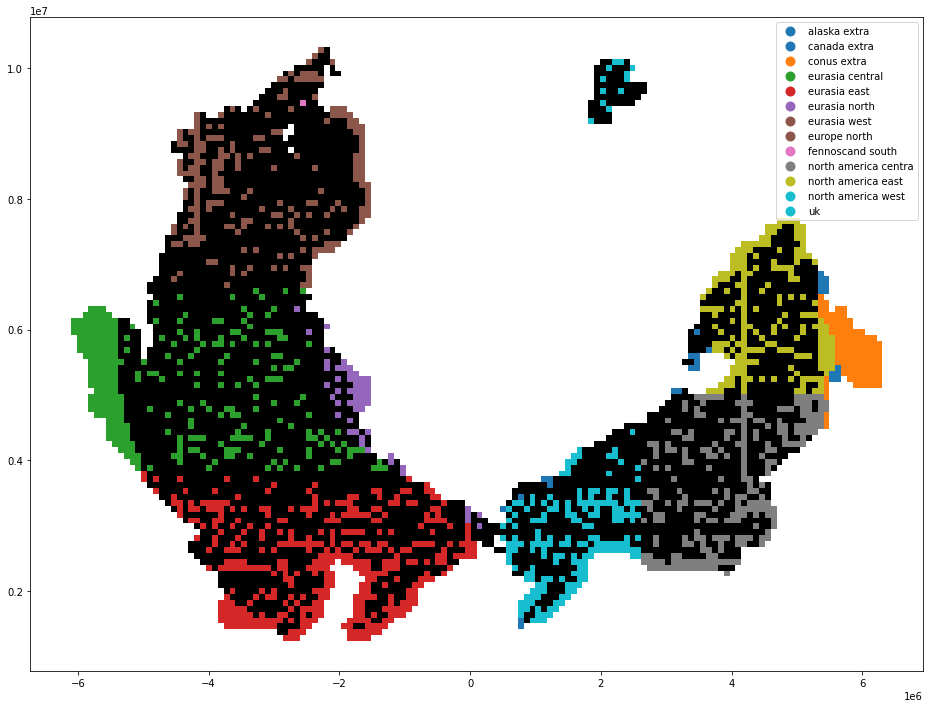

In [8]:
AGB_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'AGB', \
                                                tindex_master_fn = AGB_tindex_master_fn,\
                                                boreal_tile_index_path = boreal_tile_index_path)

In [9]:
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

# For the tindex_master, convert it into vector tiles that show the tiles we have
cols_list = ['tile_num','s3_path','local_path']

# Select the rows we have results for
tile_index_matches = boreal_tile_index.merge(tindex_master[~tindex_master['tile_num'].isin(BAD_TILE_LIST)][cols_list], how='right', on='tile_num')
tile_index_matches = tile_index_matches[tile_index_matches['s3_path'].notna()]
tile_index_matches.head()

,tile_num,tile_version,tile_group,map_version,geometry,s3_path,local_path
0,1533,version 1,eurasia central,None,"POLYGON ((-3591478.000 5373304.000, -3501478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
1,2325,version 1,eurasia central,None,"POLYGON ((-3771478.000 4293304.000, -3681478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
2,3347,version 1,eurasia east,None,"POLYGON ((-981478.000 3213304.000, -891478.000...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
3,2669,version 1,north america west,None,"POLYGON ((1898522.000 3933304.000, 1988522.000...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
4,3692,version 1,eurasia east,None,"POLYGON ((-3321478.000 2853304.000, -3231478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...


## Build a MosaicJSON

##### Build tile geojsons needed for mosaic jsons

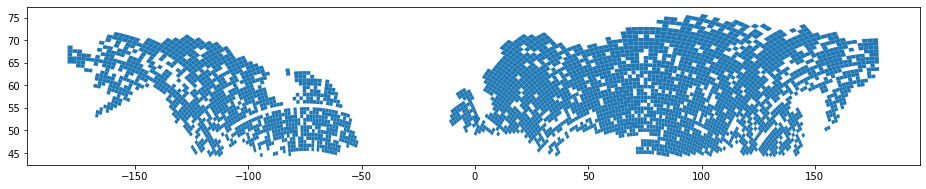

In [10]:
# Corrections were made to ensure GeoJSON *_tindex_master.json was set correctly to 4326
tile_matches_geojson_string = tile_index_matches.to_crs("EPSG:4326")

#Write copy to disk for debug 
tile_matches_geojson_string.to_file(tile_matches_geojson_fn, driver='GeoJSON')

tile_matches_geojson_string.plot()
tile_matches_geojson_string = tile_matches_geojson_string.to_json()

# This is formatted nicely (printed)
tile_matches_geojson = json.loads(tile_matches_geojson_string)

In [11]:

from typing import Dict
from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

def get_accessor(feature: Dict):
    """Return specific feature identifier."""
    return feature["properties"]["s3_path"]

#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 
#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/alexdevseed/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 

print(f"Building {out_mosaic_json_fn}")
mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

with MosaicBackend(out_mosaic_json_fn, mosaic_def=mosaicdata) as mosaic:
    mosaic.write(overwrite=True)

Building /projects/my-public-bucket/DPS_tile_lists/v2/AGB_tindex_master_mosaic.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,
